In [2]:
import re
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D

# But what influence will it have if the modeled region is lager?

class NormVector3D:
    def __init__(self):
        self.rand_on_sphere()

    def x(self):
        return self.vec[0]
    
    def y(self):
        return self.vec[1]

    def z(self):
        return self.vec[2]

    '''
    Note the inefficiency of this implementation: about 0.1s for one rand vec
    '''
    def rand_on_sphere(self):
        for_select = np.random.rand(3) * 2 - 1
        for _ in range(int(1e2)):
            this_vec = np.random.rand(3) * 2 - 1
            if self.get_norm(this_vec) < 1:
               for_select = np.vstack((for_select, this_vec))
        row = for_select.shape[0]
        self.vec = for_select[int(np.random.rand() * row), :]
        self.normalize()

    def rand_on_sphere_faster1(self):
        vec = np.random.rand(3) * 2 - 1
        while self.get_norm(vec) > 1:
            vec = np.random.rand(3) * 2 - 1
        self.vec = vec
        self.normalize()
    
    def normalize(self):
        self.vec /= self.get_norm(self.vec)

    @staticmethod
    def get_norm(vec):
        if isinstance(vec, NormVector3D):
            return np.sqrt(np.sum(np.abs(vec.vec) ** 2))
        else:
            return np.sqrt(np.sum(np.abs(vec) ** 2))

    @staticmethod
    def innerProduct(vec1, vec2):
        return vec1.vec@vec2.vec




In [3]:
'''
Only 4 atoms in a unit cell that are independent if periodic boundary condition is adopted?
Set k_B as 1
'''
class FCC:
    def __init__(self, N):
        '''
        N * N * N cells
        '''
        self.N = N
        self.vertices = np.empty((2 * N, 2 * N, 2 * N), dtype='object') # i, j, k cannot simultaneously be odd number
        def init(i, j, k):
            self.vertices[i, j, k] = NormVector3D()
        self.traverse(init)
        self.H = self.get_H_total()
    
    def traverse(self, f, *args):
        N = self.N
        for i in range(2 * N):
            for j in range(2 * N):
                for k in range(2 * N):
                    if not self._is_center_or_edge(i, j, k):
                        f(i, j, k, *args)
        

    def _is_center_or_edge(self, i, j, k):
        # true iff i, j, k are all odd or one of i, j, k is odd
        return (i % 2 + j % 2 + k % 2) % 2

    
    # MAY CONTAIN BUG!!!
    def get_H_total(self):
        '''
        It is obvious that 1 particle has 12 different NNs.
        '''
        H = 0
        def get_neighbor_H(i, j, k):
            '''
            (+- 1 / 2, 0) ^ 3: 27 neighbors in total, but centers should be neglected
            '''
            nonlocal H
            H += self.get_H_local(i, j, k)
        self.traverse(get_neighbor_H)     
        return H
    
    def get_H_local(self, i, j, k):
        H = 0
        dif = [-1, 0, 1]
        for di in dif:
            ni = i + di
            for dj in dif:
                nj = j + dj
                for dk in dif:
                    nk = k + dk
                    if self._is_center_or_edge(ni, nj, nk) or not(di or dj or dk):
                        # when not a neighbor (itself) also discard
                        continue
                    # adopt periodic boundary condition
                    ni, nj, nk = self._periodic_fix(ni, nj, nk)
                    # every coupling is counted twice
                    H -= NormVector3D.innerProduct(self.vertices[i, j, k], self.vertices[ni, nj, nk])
        return H
        
    def _periodic_fix(self, i, j, k):
        if i < 0 or i >= 2 * self.N:
            i %= 2 * self.N
        if j < 0 or j >= 2 * self.N:
            j %= 2 * self.N
        if k < 0 or k >= 2 * self.N:
            k %= 2 * self.N
        return i, j, k
    
    def rand_displace(self, scale = 0.1):
        # randomly choose an atom
        i, j, k = np.random.randint(0, 2 * self.N, 3)

        # print('before fix', i, j, k)
        if self._is_center_or_edge(i, j, k):
            i += 1
        i, j, k = self._periodic_fix(i, j, k)
        # store last H
        self.last_H = self.H
        self.last_ijk = (i, j, k)
        self.last_v = self.vertices[i, j, k].vec.copy()
        # prepare for updating H
        self.H -= self.get_H_local(i, j, k)
        # print('after fix', i, j, k)
        # randomly change direction
        self.vertices[i, j, k].vec += (np.random.rand(3) * 2 - 1)
        self.vertices[i, j, k].normalize()
        # update H by only evaluating neighbors
        self.H += self.get_H_local(i, j, k)
        
        return

    def revert(self):
        # should be more efficient than copy.deepcopy?
        self.H = self.last_H
        i, j, k = self.last_ijk
        self.vertices[i, j, k].vec = self.last_v
   
    def get_avg_s(self):
        self.total_x = 0
        self.total_y = 0
        self.total_z = 0
        def get_s(i, j, k):
            self.total_x += self.vertices[i, j, k].x()
            self.total_y += self.vertices[i, j, k].y()
            self.total_z += self.vertices[i, j, k].z()
            
        self.traverse(get_s)
        # should divide by 4 N^3
        return np.sqrt(self.total_x ** 2 + self.total_y ** 2 + self.total_z ** 2) / (self.N) ** 3 / 4
        
    
def MC_Heisenberg(T, N_size=3, N_step=1000):
    res = []
    fcc = FCC(N_size)
    for _ in range(N_step):
        last_H = fcc.H
        res.append({'H': fcc.H, 's': fcc.get_avg_s()})
        # print(fcc.get_H_total())
        fcc.rand_displace()
        # H updated
        this_H = fcc.H
        if last_H > this_H:
            # accept
            # print('acc 1')
            pass
        else:
            acc_rate = np.exp(-(this_H - last_H) / T)
            if np.random.rand() > acc_rate:
                # reject
                # print('rej')
                fcc.revert()
            else:
                # accept
                pass
                # print('acc 2')
    return res
    

In [ ]:
step_N = 20000
# have no idea why changing cell number runs much slower.
# need more iterations to reach stable state
cell_number = 4
fig, ax = plt.subplots(1, 1)

for T in [0.1, 2, 3, 10]:
    res = MC_Heisenberg(T, cell_number, int(step_N))
    ax.plot(list(range(len(res))), [r['s'] for r in res], label=f's: T={T}')
ax.legend(loc='upper right')
ax.set_xlabel('step')

ax.set_ylabel('|s| / a.u.')




In [7]:
def avg(x, n=100):
    try:
        return np.sum(x[-n: -1]) / (n - 1)
    except:
        return np.sum(x[0: -1]) / len(x)

def s_to_T(cell_number, steps, Ts=np.linspace(1e-100, 10, 100), avg=lambda x: avg(x, 100)):
    # looking for Curie temperature
    res = []
    for T in Ts:
        res.append(MC_Heisenberg(T, cell_number, steps))

    last_H = []
    last_s = []
    for T, this_res in zip(Ts, res):
        last_H.append(avg([r['H'] for r in this_res]))
        last_s.append(avg([r['s'] for r in this_res]))
    # otherwise memory will soon run out...
    # if sample at 1000 temperature and each run iters 10000 times then it's 1e7 * size of float, which is ~100MB
    del res
    return Ts, {'last_H': last_H, 'last_s': last_s}

def plot(Ts, res, fig=None, ax=None, l='', c_s='orange', c_H='steelblue'):
    last_H = res['last_H']
    last_s = res['last_s']

    # plot
    if ax is None:
        fig, ax = plt.subplots(1, 1)
        axT = ax.twinx()
        axT.set_ylabel('total H / a.u.')
        axT.plot(Ts, last_H, label='H'+l, color=c_H)
        axT.legend(loc='upper right')
    else:
        assert fig is not None
    ax.plot(Ts, last_s, label='s'+l, color=c_s)
    ax.legend(loc='upper left')
    ax.set_ylabel('|s| / a.u.')
    ax.set_xlabel('T / K')

    return fig, ax


In [ ]:
cell_number = 2
steps = 20000
Ts_2, res_2 = s_to_T(cell_number, steps, Ts=np.linspace(0.001, 10, 1000))
fig, ax = plot(Ts_2, res_2, avg=lambda x: avg(x, 100), l=' avg over last 100')


ax.set_title(f'Classical Heisenberg model\n One period: {cell_number}*{cell_number}*{cell_number} cells')
fig.savefig(f'q2_s_to_T_{cell_number ** 3}cells.png', dpi=300)

In [ ]:
cell_number = 3
steps = 20000
Ts_3, res_3 = s_to_T(cell_number, steps, Ts=np.linspace(0.001, 10, 1000))
fig, ax = plot(Ts_3, res_3)

ax.set_title(f'Classical Heisenberg model\n One period: {cell_number}*{cell_number}*{cell_number} cells')
fig.savefig(f'q2_s_to_T_{cell_number ** 3}cells.png', dpi=300)

In [ ]:
cell_number = 4
steps = 20000
Ts_4, res_4 = s_to_T(cell_number, steps, Ts=np.linspace(0.001, 10, 1000))
fig, ax = plot(Ts_4, res_4)

ax.set_title(f'Classical Heisenberg model\n One period: {cell_number}*{cell_number}*{cell_number} cells')
fig.savefig(f'q2_s_to_T_{cell_number ** 3}cells.png', dpi=300)

In [ ]:
cell_number = 5
steps = 40000
Ts_4, res_4 = s_to_T(cell_number, steps)
fig, ax = plot(Ts_4, res_4)

ax.set_title(f'Classical Heisenberg model\n One period: {cell_number}*{cell_number}*{cell_number} cells')
fig.savefig(f'q2_s_to_T_{cell_number ** 3}cells.png', dpi=300)

# plot

In [ ]:


res = []
path = './res_4/'
for f in os.listdir(path):
    r = re.match('res_4_at_T=(.*)', f)
    if r is not None:
        T = float(r.group(1))
        train_process = np.loadtxt(path + f, dtype='float')
        res.append({'T': T, 'train': train_process})

dif = lambda x: [np.abs(x[i + 1] - x[i]) for i in range(x.shape[0] - 1)]
def get_avg_ith(ls):
    x = ls[i]['train']
    # low-pass filter
    l = 2000
    # x = np.hstack((np.zeros(l) + x[0], x, np.zeros(l) + x[-1]))
    return np.convolve(x, np.zeros(l) + 1)[l: -l]
    
fig, ax = plt.subplots(1, 1)
for i in list(range(0, 200, 100)) + [210, 220, 230, 240]:
    ax.plot(dif(get_avg_ith(res)), label=f"{res[i]['T']:.02f}")

ax.set_xlabel('iteration')
ax.set_ylabel('energy / a.u.')
ax.legend()
# ax.set_xlim(-100, 10000)
# ax.set_ylim(-1000, 100)

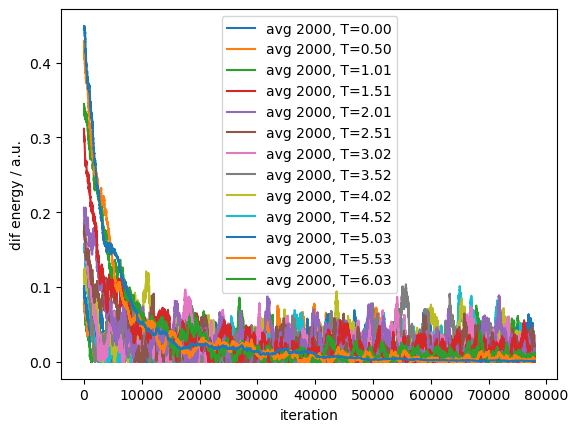

In [185]:


res = []
path = './res_5/'
for f in os.listdir(path):
    r = re.match('res_5_at_T=(.*)', f)
    if r is not None:
        T = float(r.group(1))
        train_process = np.loadtxt(path + f, dtype='float')
        res.append({'T': T, 'train': train_process})

dif = lambda x: [(np.abs(x[i + 1] - x[i])) for i in range(x.shape[0] - 1)]
def get_avg_ith(ls, l=1000):
    x = ls[i]['train']
    # low-pass filter
    # l = 1000
    # x = np.hstack((np.zeros(l) + x[0], x, np.zeros(l) + x[-1]))
    return np.convolve(x, (np.zeros(l) + 1) / l)[l: -l]
    
fig, ax = plt.subplots(1, 1)
for i in list(range(0, len(res), 10)):
    ax.plot(dif(get_avg_ith(res, 2000)), label=f"avg 2000, T={res[i]['T']:.02f}", zorder=10000-i)

ax.set_xlabel('iteration')
ax.set_ylabel('dif energy / a.u.')
ax.legend()
# ax.set_xlim(0, 10000)
# ax.set_ylim(-5, None)

In [ ]:
fig, ax = plt.subplots(1, 1)
for i in list(range(0, len(res), 30)):
    # ax.plot(dif(get_avg_ith(res)), label=f"avg 2000, T={res[i]['T']:.02f}", zorder=10000-i)
    ax.plot(dif(get_avg_ith(res, 2000)), label=f"T={res[i]['T']:.02f}")

ax.set_xlabel('iteration')
ax.set_ylabel('dif energy / a.u.')
ax.legend(loc='upper right')
ax.set_xlim(0,10000)
# ax.set_ylim(0, None)

In [ ]:
# stop decrease at roughly same iteration, regardless of filter
fig, ax = plt.subplots(1, 1)
for i in list(range(10, 20, 10)):
    ax.plot(dif(get_avg_ith(res)), label=f"avg 1000, T={res[i]['T']:.02f}", zorder=2)
    ax.plot(dif(get_avg_ith(res, 100)), label=f"avg 100, T={res[i]['T']:.02f}", zorder=1)
    ax.plot(dif(get_avg_ith(res, 2000)), label=f"avg 2000, T={res[i]['T']:.02f}", zorder=3)
    ax.plot(dif(get_avg_ith(res, 4000)), label=f"avg 2000, T={res[i]['T']:.02f}", zorder=3)
    
# ax.set_xlim(0, 10000)
# ax.set_ylim(-2, None)
ax.set_xlabel('iteration')
ax.set_ylabel('dif energy / a.u.')
ax.legend()


In [ ]:

# 1000 cells
res = []
path = './res_5_run1/'
for f in os.listdir(path):
    r = re.match('H_5_at_T=(.*)', f)
    if r is not None:
        T = float(r.group(1))
        train_process = np.loadtxt(path + f, dtype='float')
        res.append({'T': T, 'train': train_process})

dif = lambda x: [(np.abs(x[i + 1] - x[i])) for i in range(x.shape[0] - 1)]
def get_avg_ith(ls, l=1000):
    x = ls[i]['train']
    # low-pass filter
    # l = 1000
    # x = np.hstack((np.zeros(l) + x[0], x, np.zeros(l) + x[-1]))
    return np.convolve(x, (np.zeros(l) + 1) / l)[l: -l]
    
fig, ax = plt.subplots(1, 1)
for i in list(range(60, 80, 3)):
    ax.plot((get_avg_ith(res, 100)), label=f"T={res[i]['T']:.02f}", zorder=10000-i)

ax.set_xlabel('iteration')
ax.set_ylabel('energy / a.u.')
ax.legend()
ax.set_xlim(0, 10000)
ax.set_ylim(-800, None)

# s-T Plot

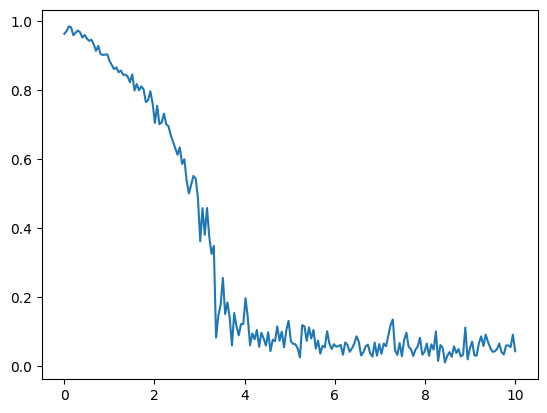

In [8]:
T = np.loadtxt('./res_5_run1/all_T', dtype='float')
s1 = np.loadtxt('./res_5_run1/all_s', dtype='float')
s2 = np.loadtxt('./res_5_run2/all_s', dtype='float')
s3 = np.loadtxt('./res_5_run3/all_s', dtype='float')

fig, ax = plt.subplots(1, 1)
ax.plot(T, s2)

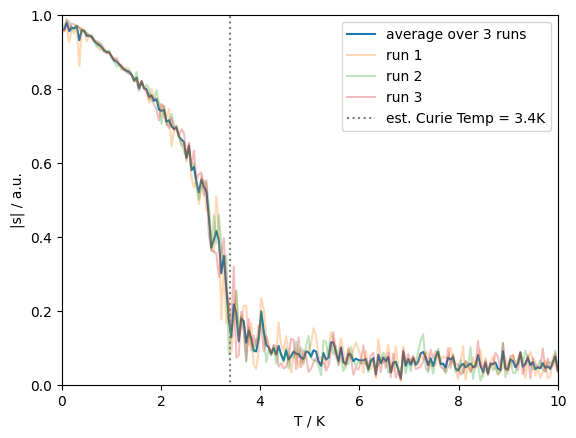

In [20]:
T = np.loadtxt('./res_5_run2/all_T', dtype='float')
s2 = np.loadtxt('./res_5_run2/all_s', dtype='float')

fig, ax = plt.subplots(1, 1)
ax.plot(T, (s1 + s2 + s3) / 3, c='C0', label='average over 3 runs')
ax.plot(T, s1, c='C1', alpha=0.3, label='run 1')
ax.plot(T, s2, c='C2', alpha=0.3, label='run 2')
ax.plot(T, s3, c='C3', alpha=0.3, label='run 3')
ax.plot([3.4, 3.4], ax.get_ylim(), ls=':', c='grey', label='est. Curie Temp = 3.4K')

ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(0, 10)
ax.set_xlabel('T / K')
ax.set_ylabel('|s| / a.u.')
fig.savefig('q2.png', dpi=300)